### Anharmonic Oscillator with RBMs

We want to try creating an emulator using RBMs for the anharmonic oscillator problem from the CAT plot focus Challenge. 

For this problem, we are finding a reduced-basis for the Hamiltonian 
\begin{equation}
    H = -\frac{\partial^2}{\partial x^2} + \kappa_1 x^2 + \kappa_2 x^2,
\end{equation}
as a function of $\kappa_1 \in [0.5,4]$ and $\kappa_2 \in [0,2]$.

To begin, we start with importing the standard requisite packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["font.size"]=20
import time
from scipy.sparse import diags
from scipy.stats import qmc
from scipy import optimize


Next, we define functions that will yield exact solutions (a la code from Josh). From the exact solutions, we will build the RBM emulator using the Galerkin projection. 

In [2]:
def build_mesh(domain,nsteps):
    mesh, dx = np.linspace(domain[0], domain[1], nsteps, retstep=True)
    mesh     = np.resize(mesh, (nsteps,))
    
    return mesh, dx

def dx2_matrix(mesh,dx):
    dx2 = diags([1, -2, 1], [-1, 0, 1], shape=(mesh.shape[0], mesh.shape[0]))  / ( dx ** 2 )

    return dx2

def H_matrix(params,mesh,dx):
    H = -dx2_matrix(mesh,dx) + diags( params[0] * mesh ** 2  +  params[1] * mesh ** 4).toarray()

    return np.array(H)

def exact_solution(params,mesh,dx):
    
    H = H_matrix(params,mesh,dx)

    eigenvalues, eigenvectors = np.linalg.eig(H)
    sort_index                = np.argsort(eigenvalues)
    eigenvalues               = eigenvalues[sort_index]
    eigenvectors              = eigenvectors[:,sort_index].T
    evect = np.resize(eigenvectors[0], (mesh.shape[0],))
    
    return eigenvalues[0], evect

With a quick check of the ground state solution for $[\kappa_1, \kappa_2] = [4,2]$.

2.283797632467061


Text(0.5, 1.0, 'Ground State Eigenvector from Diagonalization')

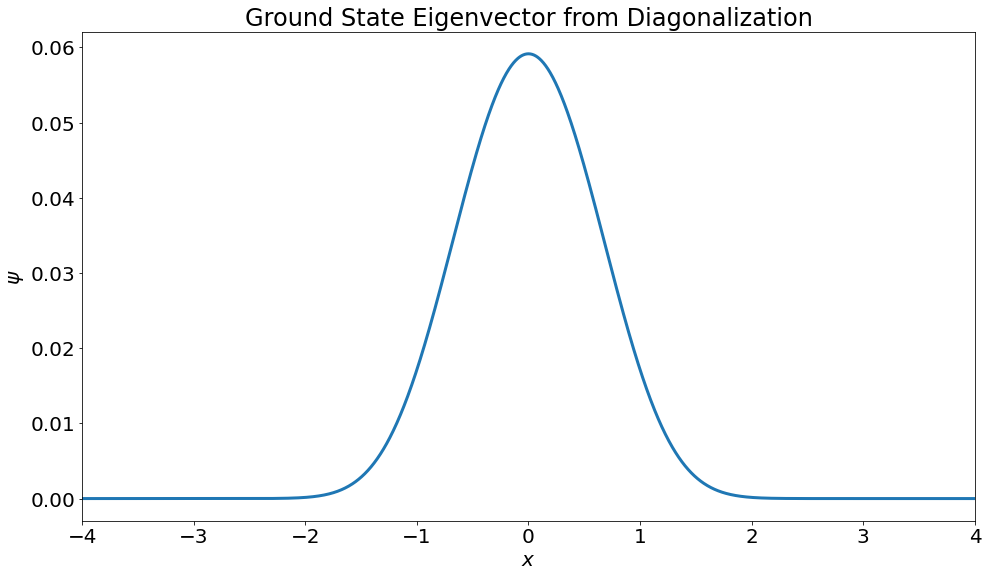

In [3]:
mesh, dx = build_mesh((-4,4),2000)
eigenvalue, eigenvector = exact_solution([4,2],mesh,dx)
print(eigenvalue)
plt.plot(mesh,eigenvector,linewidth=3)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi$")
plt.xlim((-4,4))
plt.title("Ground State Eigenvector from Diagonalization")

For the next part, we draw 10 samples on a Latin Hypercube. Using these samples, we evaluate the exact solution to the anharmonic oscillator. The exact solutions will then be utilized to train the RBM emulator. 

In [4]:
sampler = qmc.LatinHypercube(d=2,seed=193953)
samples = sampler.random(5)
l_bounds = [0.5,0]
u_bounds = [4,2]
sample_scaled = qmc.scale(samples, l_bounds, u_bounds)
exact_samples       = [exact_solution(sample,mesh,dx) for sample in sample_scaled]
eigenvalue_samples  = [exact_samples[i][0] for i in range(len(samples))]
eigenvector_samples = np.array([exact_samples[i][1] for i in range(len(samples))])

Text(0.5, 1.0, 'Training Wave Functions')

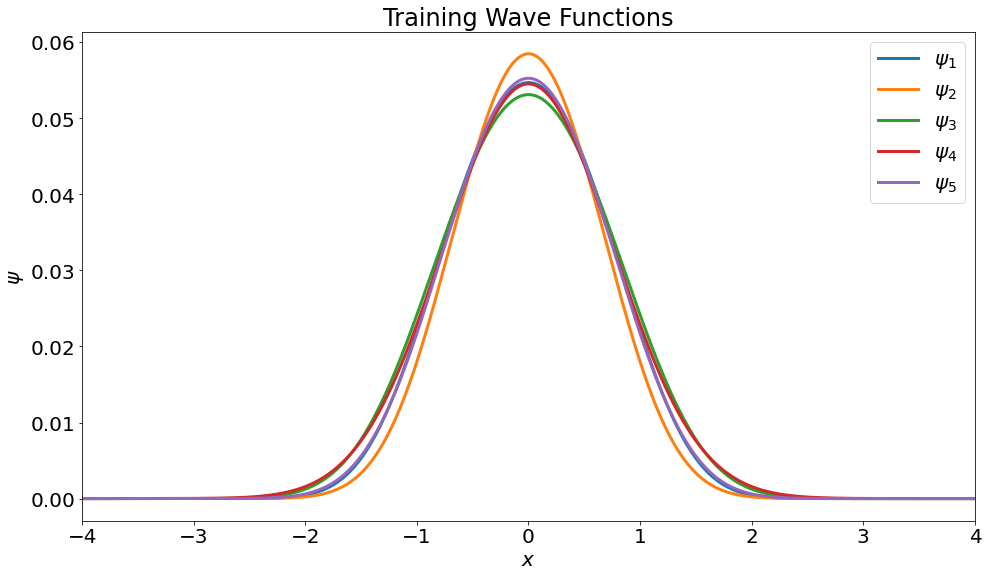

In [5]:
for i in range(len(samples)):
    plt.plot(mesh,np.abs(eigenvector_samples[i]),linewidth=3)
plt.xlabel(r"$x$")
plt.ylabel(r"$\psi$")
plt.xlim((-4,4))
labels = [r"$\psi_1$",r"$\psi_2$",r"$\psi_3$",r"$\psi_4$",r"$\psi_5$"]
plt.legend(labels)
plt.title("Training Wave Functions")

### Singular Value Decomposition

From the training data, we can perform a SVD to investigate the principal components of the 5 training solutions.

In [6]:
U, s ,Vh = np.linalg.svd(eigenvector_samples)

/var/folders/1p/9d8ppj4d6wxdv8qd21krfr280000gn/T/ipykernel_60658/777937334.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


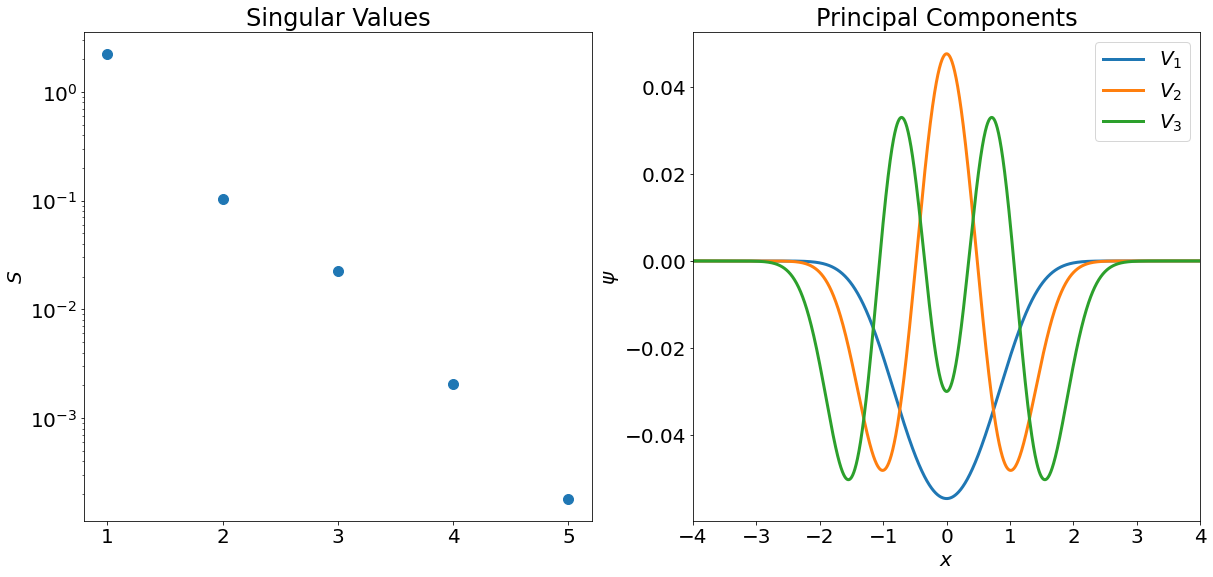

In [7]:
nbasis = 3
fig, ax = plt.subplots(1,2)
ax[0].scatter([1,2,3,4,5],s,s=100)
ax[0].set_yscale('log')
ax[0].set_ylabel(r"$S$")
ax[0].set_title("Singular Values")
for i in range(nbasis):
    ax[1].plot(mesh,Vh[:,i],linewidth=3)
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$\psi$")
ax[1].set_title("Principal Components")
ax[1].legend([r"$V_1$",r"$V_2$",r"$V_3$"])
ax[1].set_xlim((-4,4))
fig.set_size_inches((20,9))
fig.show()

From investigating the singular values (i.e. the plot on the left), we can notice an exponential decay in the singular value spectrum. This indicates that a reduction in the dimensionallity of the problem may be feesible. On the right, we have plotted the first three principal components of the training data. These three componenents we use to construct the basis $\{\phi_k\}$ for the emulator. From this basis, we construct the emulator states as a linear combination of the $\{\phi_k\}$ as 
\begin{equation}
    |\hat{\phi}\rangle = \sum_{k=1}^3 a_k |\phi_k \rangle
\end{equation}

In [8]:
nbasis=3
judges = Vh[:,:nbasis].T.copy()
phi = Vh[:,:nbasis].T.copy()

### Galerkin Projection

From here, we can now define the equations neccessary to perform the Galerkin projection. The Galerkin projection, in its general form for the bound system is determined by a system of equations as
\begin{equation}
    \sum_{k=1}^n a_k \langle \phi_j | H_\alpha | \phi_k \rangle = \hat{\lambda}_\alpha \sum_{k=1}^n a_k \langle \phi_j | \phi_k \rangle, \quad \forall j,
\end{equation}
where $\hat{\lambda}_\alpha$ is the approximate eigenvalue for the projected Hamiltonian $\hat{H}_\alpha |\hat{\phi}\rangle = \hat{\lambda}_\alpha |\hat{\phi}\rangle$. From this projection, we can identify a set of $n$ equations, which determines the $n$ $\{a_k\}$ coefficients. Upon this identification, one may worry that we have a underdetermined set of equations, given that $\hat{\lambda}_\alpha$ is unknown. However, we can add an additional constraint by requiring the normalization of $\langle \phi_i | \phi_i \rangle = 1$. With this, we then arrive at $n+1$ equations to fully determine the system of $n+1$ unknowns of $\{a_k,\hat{\lambda}_\alpha \}$.

In [9]:
def Galerkin_matrix_projection(H_unsolved,judges,phi):

    def Galerkin_equations(a_k):
        optimized_a_k = np.zeros(a_k.size)
        optimized_a_k[-1] = -1
        optimized_a_k[:-1] = judges @ H_unsolved @ (a_k[:-1] @ phi) - a_k[-1] * judges @ (a_k[:-1] @ phi)
        optimized_a_k[-1] += (a_k[:-1] @ judges)@(a_k[:-1] @ phi)
    
        return optimized_a_k
    
    return Galerkin_equations

Now we can look at some unknown set of parameters for which we did not yet solve the problem. So, we choose say $[\kappa_1, \kappa_2] = [1,2]$, and extract the ground state eigenvalue and eigenvector.

In [10]:
H_unknown = H_matrix([1,2],mesh,dx)
H_unknown_eigenvalue, H_unknown_eigenvector = exact_solution([1,2],mesh,dx)

Next, we can run the emulator to see how this performs. If we look above to how the Gelerkin projection is defined, we end up $n+1$ equations that all must equal zero. More succinctly,
\begin{equation}
    \sum_{k=1}^n a_k \langle \phi_j |H_\alpha - \hat{\lambda}_\alpha | \phi_k \rangle = 0, \quad (n \, \mathrm{equations})
\end{equation}

\begin{equation}
    \left(\sum_{j,k=1}^n a_k a_j \langle \phi_j | \phi_k \rangle\right) - 1 = 0, \quad (1 \, \mathrm{equation}).
\end{equation}
These equations we can solve using a generic function in `python`, which in this case we choose `scipy.optimize.fsolve`.

By solving these equations, we obtain the $\{a_k\}$ coefficients, from which we can construct the ground state eigenvalue, and the eigenvalue $\hat{\lambda}_\alpha$. The emulated results we can directly compare to the numerical values extract by diagonlaizing the Hamiltonian. 

Total emulator time      = 0.08594393730163574 s
Emulator coefficients    = [ 0.99997355 -0.00711275 -0.00151886]
Emulator eigenvalue      = 1.607541052627984
Numerical eigenvalue     = 1.60753763450939
Eigenvalue residual      = 3.4181185941672965e-06
Max eigenvector residual = 1.367640182184035e-05


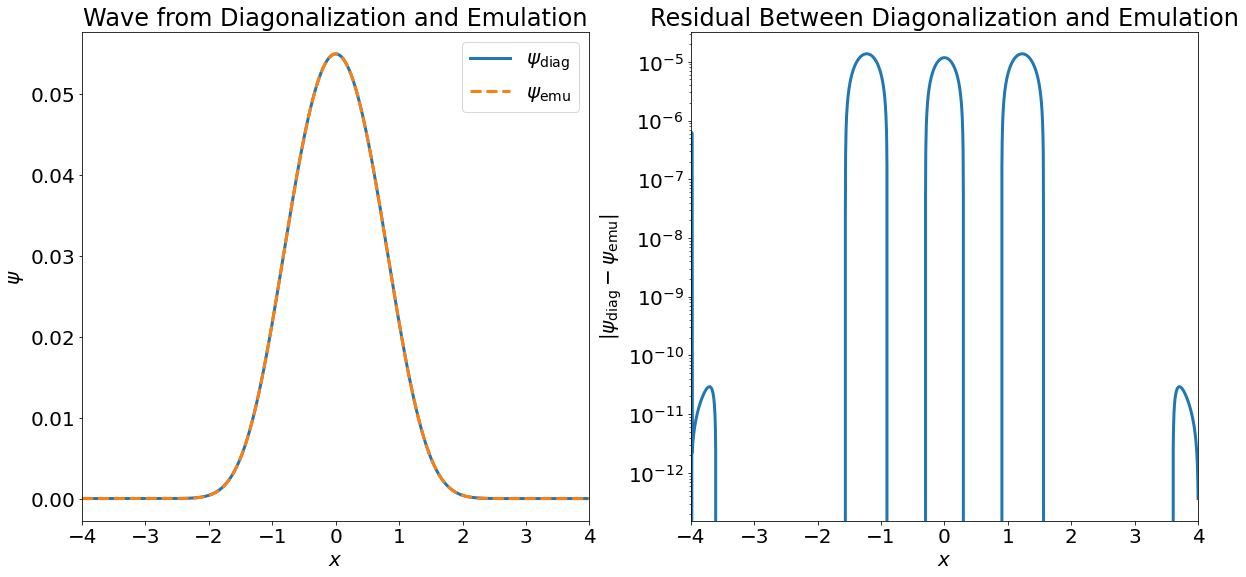

In [11]:
Galerkin_equations = Galerkin_matrix_projection(H_unknown,judges,phi)
a_k_guess = np.zeros(judges.shape[0]+1)
a_k_guess[0] = 1
start_time = time.time()
a_solutions = optimize.root(Galerkin_equations,a_k_guess).x
end_time = time.time()
residual = -H_unknown_eigenvector-(a_solutions[:-1] @ phi)
print("Total emulator time      = {0} s".format(end_time - start_time))
print("Emulator coefficients    = {0}".format(a_solutions[:-1]))
print("Emulator eigenvalue      = {0}".format(a_solutions[-1]))
print("Numerical eigenvalue     = {0}".format(H_unknown_eigenvalue))
print("Eigenvalue residual      = {0}".format(np.abs(a_solutions[-1]-H_unknown_eigenvalue)))
print("Max eigenvector residual = {0}".format(np.max(residual)))

fig, ax = plt.subplots(1,2)
ax[0].plot(mesh,H_unknown_eigenvector,linewidth=3)
ax[0].plot(mesh,-a_solutions[:-1] @ phi,linestyle='--',linewidth=3)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$\psi$")
ax[0].set_xlim((-4,4))
ax[0].legend([r"$\psi_\mathrm{diag}$",r"$\psi_\mathrm{emu}$"])
ax[0].set_title("Wave from Diagonalization and Emulation")
ax[1].semilogy(mesh,residual,linewidth=3)
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$|\psi_\mathrm{diag} - \psi_\mathrm{emu}|$")
ax[1].set_xlim((-4,4))
ax[1].set_title("Residual Between Diagonalization and Emulation")
fig.set_size_inches(20,9)

Would you look at that! The emulated results closely match those of the matrix diagonalization. This goes to show the power of the Galerkin projection for emulating the solutions.

Finally, we can look at the average time to run the emulator. Recall that the matrix diagonlization takes on the order to 10s.

In [12]:
sampler_2 = qmc.LatinHypercube(d=2,seed=12003958)
nsamples = 500
samples_2 = sampler_2.random(nsamples)
l_bounds = [0.5,0]
u_bounds = [4,2]
sample_scaled_2 = qmc.scale(samples_2, l_bounds, u_bounds)
root_sols = []
start_root = time.time()
for sample in sample_scaled_2:
    H_emu = H_matrix(sample,mesh,dx)
    Gerlerkin_equations = Galerkin_matrix_projection(H_emu,judges,phi)
    a_solutions = optimize.root(Gerlerkin_equations,a_k_guess).x
    root_sols.append(a_solutions)
end_root = time.time()
print("Average emulator time   = {0}".format((end_root - start_root)/nsamples))

Average emulator time   = 0.05816985607147217


We can see that we go from ~10s to 50-60ms. This offers a drastic speed up, at little cost of computational accuracy.